# DEMO: Vanilla GAN tạo hình ảnh từ vector nhiễu
Dataset: MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

GPU is available!
Device: Tesla T4


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
latent_dim = 100
batch_size = 64
learning_rate = 0.0002
num_epochs = 200

In [ ]:
# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

!rm -rf progress
!mkdir progress

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.26MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [ ]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
# Initialize the models and optimizers
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

In [ ]:
# Load pretrained model

# generator.load_state_dict(torch.load('progress/generator_epoch_200.pth', map_location=torch.device('cpu')))
# discriminator.load_state_dict(torch.load('progress/discriminator_epoch_200.pth', map_location=torch.device('cpu')))

In [ ]:
# Training loop
D_losses = []
G_losses = []

generator.train()
discriminator.train()

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Print training progress
        if i % 400 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, Loss G: {g_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(), 'progress/generator_epoch_{}.pth'.format(epoch + 1))
            torch.save(discriminator.state_dict(), 'progress/discriminator_epoch_{}.pth'.format(epoch + 1))
            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

Epoch [0/200] Batch 0/938                   Loss D: 0.6956, Loss G: 0.7284
Epoch [0/200] Batch 400/938                   Loss D: 0.0117, Loss G: 18.4306
Epoch [0/200] Batch 800/938                   Loss D: 0.0714, Loss G: 7.6911
Epoch [1/200] Batch 0/938                   Loss D: 0.0133, Loss G: 5.0031
Epoch [1/200] Batch 400/938                   Loss D: 0.0640, Loss G: 3.7039
Epoch [1/200] Batch 800/938                   Loss D: 0.1668, Loss G: 2.7791
Epoch [2/200] Batch 0/938                   Loss D: 0.1514, Loss G: 6.7909
Epoch [2/200] Batch 400/938                   Loss D: 0.0715, Loss G: 6.5319
Epoch [2/200] Batch 800/938                   Loss D: 0.0818, Loss G: 3.5116
Epoch [3/200] Batch 0/938                   Loss D: 0.0650, Loss G: 5.0716
Epoch [3/200] Batch 400/938                   Loss D: 0.0218, Loss G: 6.5258
Epoch [3/200] Batch 800/938                   Loss D: 0.1417, Loss G: 7.5785
Epoch [4/200] Batch 0/938                   Loss D: 0.0439, Loss G: 5.0093
Epoch [4

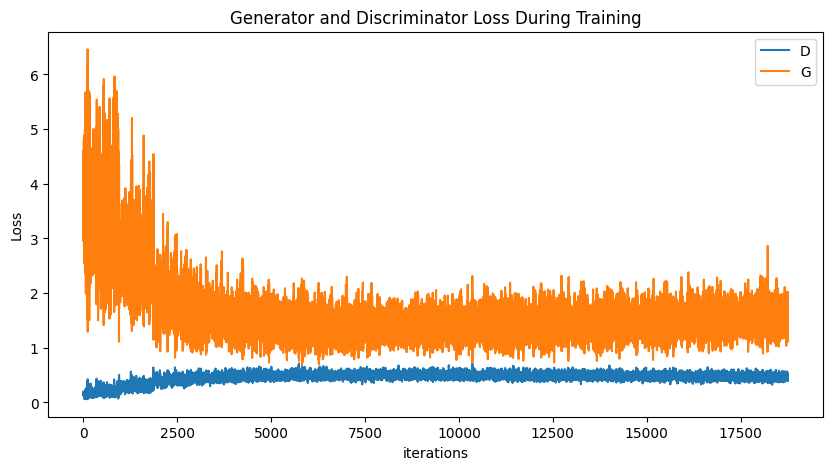

In [ ]:
import matplotlib.pyplot as plt

# Assuming D_losses and G_losses are populated from the training loop
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D")
plt.plot(G_losses, label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
generator.eval()
# discriminator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Tanh()
  )
)

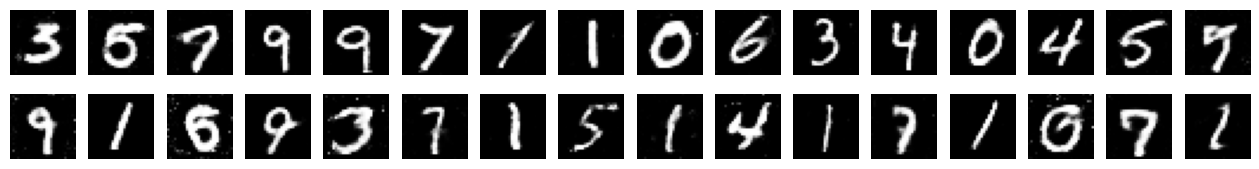

In [ ]:
import matplotlib.pyplot as plt
# Generate and visualize some images
z = torch.randn(32, latent_dim).to(device)
gen_imgs = generator(z).detach().cpu().numpy()

# fig, axes = plt.subplots(1, 16, figsize=(16, 2))
# for i, ax in enumerate(axes):
#     ax.imshow(gen_imgs[i, 0], cmap='gray')
#     ax.axis('off')
# plt.show()

fig, axes = plt.subplots(2, 16, figsize=(16, 2))

# Iterate through the grid of axes using nested loops
for i in range(2):  # Iterate through rows
    for j in range(16):  # Iterate through columns
        axes[i, j].imshow(gen_imgs[i * 16 + j, 0], cmap='gray')  # Access the correct image
        axes[i, j].axis('off')

plt.show()